In [7]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 10)
import matplotlib.pyplot as plt

import numpy as np
import scipy as sci

In [8]:
import scipy.ndimage.interpolation as inter

def affinetrans(im,trans):
    # trans[0] = scale, trans[1] = angle, trans[2] = xshift, trans[3] = yshift

    xdim,ydim = np.shape(im)
    xgrid = np.linspace(0,xdim-1,xdim) - xdim/2.
    ygrid = np.linspace(0,ydim-1,ydim) - ydim/2.
    ygrid, xgrid = np.meshgrid(ygrid,xgrid)

    xout = trans[0]*np.cos(trans[1])*xgrid - trans[0]*np.sin(trans[1])*ygrid + trans[2] + xdim/2.
    yout = trans[0]*np.sin(trans[1])*xgrid + trans[0]*np.cos(trans[1])*ygrid + trans[3] + ydim/2.

    xout, yout = xout.flatten(), yout.flatten()
    coords = np.vstack((xout,yout))

    newim = inter.map_coordinates(im, coords, order=1, mode='constant')
    return np.reshape(newim,(xdim,ydim))

0.0
514.125


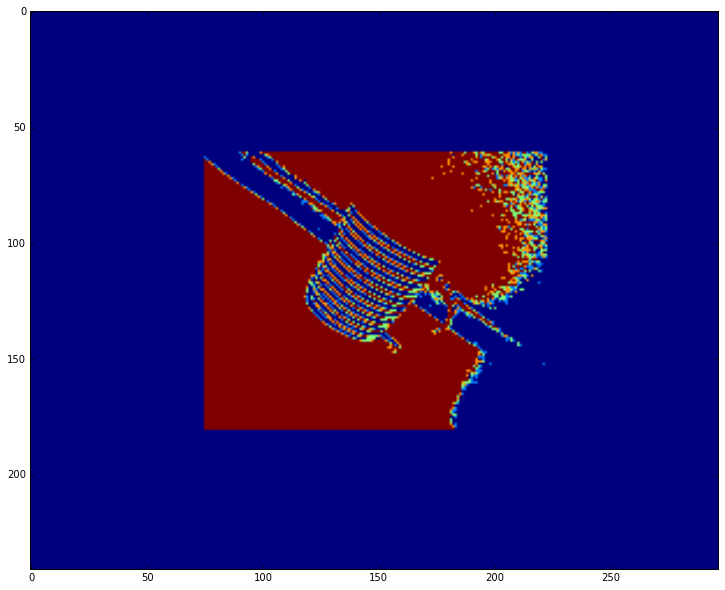

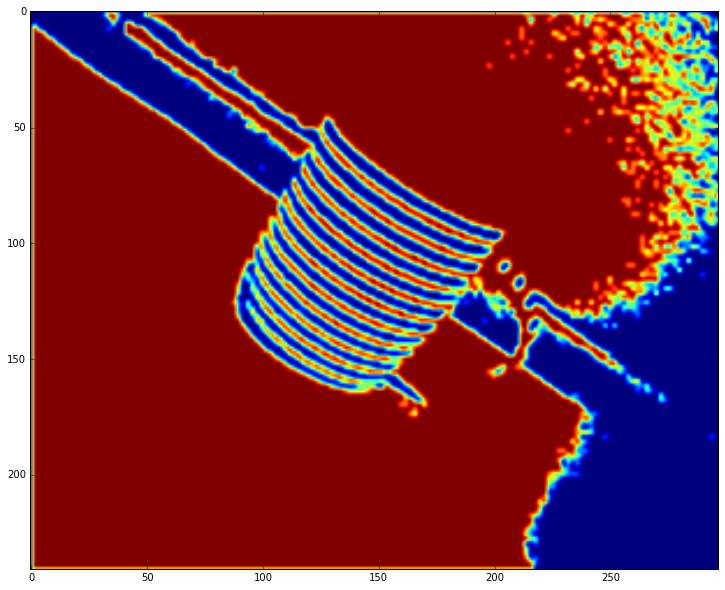

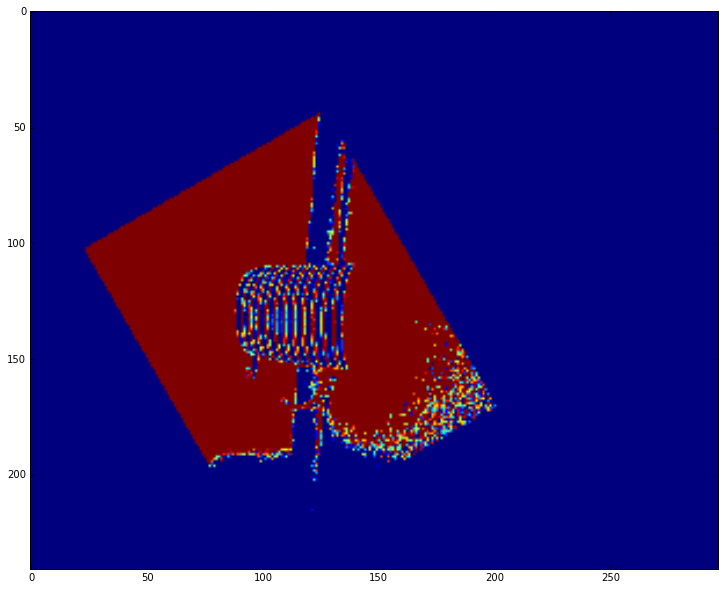

In [10]:
### Tests
if __name__ == '__main__':
    im = plt.imread('pics/2a.png')

    # Identity -- should be 0
    newim = affinetrans(im,[1,0,0,0])
    print(np.sum(im-newim))

    newim = affinetrans(im,[2,0,0,0])
    plt.figure()
    plt.imshow(newim)
    
    newim2 = affinetrans(newim,[0.5,0,0,0])
    plt.figure()
    plt.imshow(newim2)
    print (np.sum(im-newim2))

    newim = affinetrans(im,[2,np.pi/3,-80.3,8.7])
    plt.figure()
    plt.imshow(newim)

In [16]:
def c2p(im):
    #map from cartesian to polar coordinates
    nx , ny = np.shape(im) 
    rg = np.logspace(0, np.log10(np.min((nx/2., ny/2.))),nx) #why logspace??
    #rg = np.linspace(0, np.min((nx/2., ny/2.)),nx)
    thetag = np.linspace(0, 2*np.pi, ny)
    thetagrid, rgrid = np.meshgrid(thetag, rg)
    x = rgrid*np.cos(thetagrid) + nx/2. -1
    y = rgrid*np.sin(thetagrid) + ny/2. -1
    return sci.ndimage.map_coordinates(im, [y,x], order=3)

def highpass(h,w):
    eta1 = np.cos(np.pi*np.linspace(-0.5,0.5,h))
    eta = np.ones((1,np.shape(eta1)[0]))*eta1
    neta1 = np.cos(np.pi*np.linspace(-0.5,0.5,w))
    neta = np.ones((1,np.shape(neta1)[0]))*neta1
    X = np.dot(eta.T,neta)
    return (1.0-X)*(2.0-X)

def subplotter(x,y,z,colour = 'gray',title = ''):
    plt.figure() 
    plt.subplot(131) 
    plt.imshow(x, cmap=colour), plt.title(title + "Original Image")
    plt.subplot(132) 
    plt.imshow(y, cmap=colour), plt.title(title + "Translated Image")
    plt.subplot(133) 
    plt.imshow(z, cmap=colour), plt.title(title + "Rotated Image")
    
def fourier(x,y,z):
    return np.fft.fftshift(np.fft.fft2(x)),np.fft.fftshift(np.fft.fft2(y)),np.fft.fftshift(np.fft.fft2(z))

def conj(x,y,z):
    return x*np.conj(x),x*np.conj(y),z*np.conj(z)

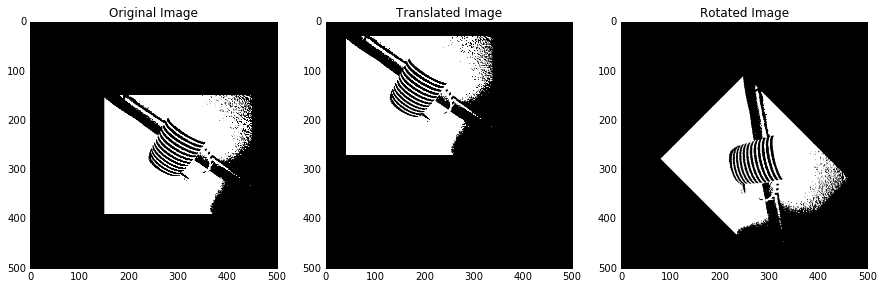

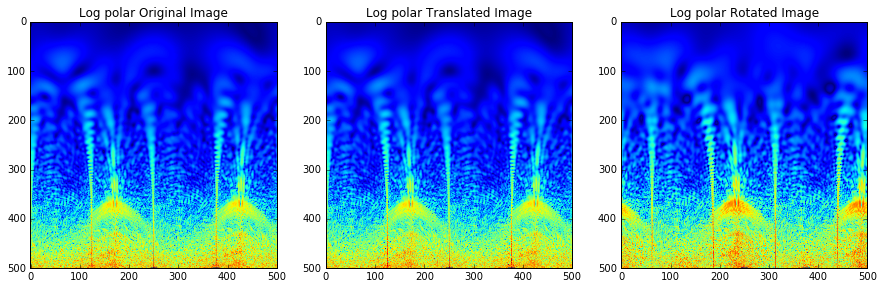

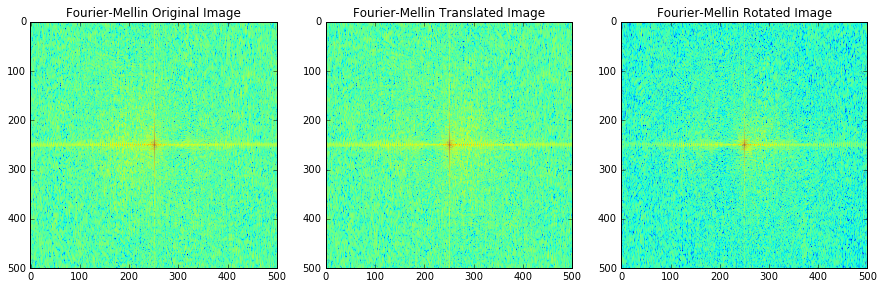

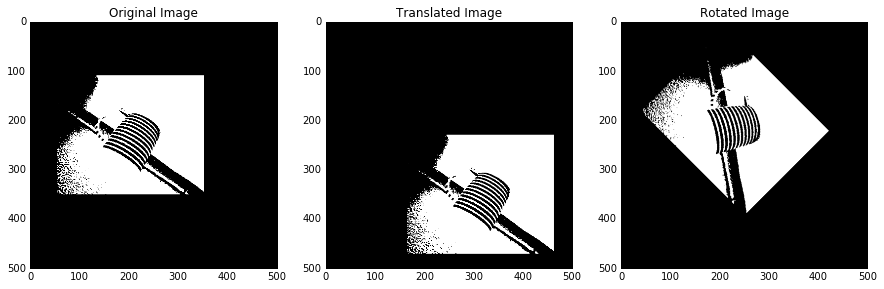

In [15]:
if __name__ = '__main__':
    im = plt.imread('pics/2a.png')

    xdim,ydim = np.shape(im)
    fullsize = 500
    h = highpass(fullsize,fullsize)

    I = np.zeros((fullsize,fullsize))
    xstart = 150
    ystart = 150
    I[xstart:xdim+xstart,ystart:ydim+ystart] = im
    J = affinetrans(I,[1,0,120,110])
    K = affinetrans(I,[1,np.pi/4,0,0])

    #plot the original image and affine translations
    subplotter(I,J,K) 

    fI,fJ,fK = fourier(I,J,K)
    ffI,ffJ,ffK = conj(fI,fJ,fK)
    #transform to polar coordinates
    pI = c2p(h*np.abs(fI))
    pJ = c2p(h*np.abs(fJ))
    pK = c2p(h*np.abs(fK))
    subplotter(np.log(np.abs(pI)+1),np.log(np.abs(pJ)+1),np.log(np.abs(pK)+1),colour = None,title = 'Log polar ')

    gI,gJ,gK = fourier(pI,pJ,pK)

    subplotter(np.log(np.abs(gI)),np.log(np.abs(gJ)),np.log(np.abs(gK)),colour = None,title = 'Fourier-Mellin ')

    subplotter(np.abs(np.fft.fft2(fI)),np.abs(np.fft.fft2(fJ)),np.abs(np.fft.fft2(fK)))